In [1]:
%matplotlib notebook

In [2]:
# Import dependencies

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os, sys
import geopandas
from shapely.geometry import Point


# from pprint import pprint
# from config import api_keys


# Wrangling the Data

The code below traverses loaded csvs obtained from World Bank.

In [3]:
# Import data

filename1 = 'Resources/country_population.csv'
filename2 = 'Resources/fertility_rate.csv'
filename3 = 'Resources/life_expectancy.csv'

country_population = pd.read_csv(filename1)
fertility_rate = pd.read_csv(filename2)
life_expectancy = pd.read_csv(filename3)



In [4]:
# Cleaning up life expectancy data frame.
# Transposes dataframe and drops rows that aren't needed for calculations.


life_expectancy_transposed = life_expectancy.transpose()
life_expectancy_transposed.columns = life_expectancy_transposed.iloc[0]
life_expectancy_transposed = life_expectancy_transposed.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
life_expectancy_transposed = life_expectancy_transposed.dropna(axis = 'columns',how = 'any')

life_expectancy_transposed.head()


Country Name,Aruba,Afghanistan,Angola,Albania,Arab World,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,...,"Venezuela, RB",Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,65.662,32.292,33.251,62.279,46.8251,52.265,65.022,65.971,62.115,70.8171,...,59.253,66.2249,59.041,46.441,52.5717,49.748,34.361,52.215,45.124,51.565
1961,66.074,32.742,33.573,63.298,47.4077,53.312,65.141,66.402,62.555,70.9732,...,59.829,66.488,59.722,47.044,53.0775,50.249,34.471,52.559,45.502,51.938
1962,66.444,33.185,33.914,64.187,47.9889,54.349,65.233,66.837,62.979,70.9424,...,60.395,66.7411,60.391,47.648,53.5016,50.75,34.739,52.894,45.869,52.3
1963,66.787,33.624,34.272,64.911,48.5722,55.375,65.311,67.276,63.385,70.9117,...,60.948,66.9962,61.024,48.251,54.0355,51.252,35.187,53.229,46.225,52.651
1964,67.113,34.06,34.645,65.461,49.1592,56.385,65.388,67.715,63.774,70.881,...,61.488,67.2604,61.585,48.853,54.7152,51.756,35.815,53.571,46.574,52.993


In [5]:
# Life expectancy averages from last 10 years

LE_10years = life_expectancy_transposed.iloc[range(46,57),:]

avg_life_10_years = pd.DataFrame(LE_10years.mean().sort_values(ascending = False))
avg_life_10_years = avg_life_10_years.rename(columns = {0 : 'Avg Life Expectancy (2006-2016)'})
avg_life_10_years = avg_life_10_years.reset_index()

avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Hong Kong SAR, China",83.277384
1,Japan,83.052417
2,"Macao SAR, China",82.877000
3,Switzerland,82.427051
4,Italy,82.106430


In [6]:
# Set criteria for highest where highest is 80 years and above.
# 26 countries fall under this criteria

top_avg_life_10_years = avg_life_10_years.loc[avg_life_10_years["Avg Life Expectancy (2006-2016)"] > 80]
top_avg_life_10_years = top_avg_life_10_years.drop(index = 14).reset_index(drop = True)  # drops 'euro area' because it's not a country

top_avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Hong Kong SAR, China",83.277384
1,Japan,83.052417
2,"Macao SAR, China",82.877000
3,Switzerland,82.427051
4,Italy,82.106430


In [7]:
# Set criteria for lowest life expectancy where lowest is 60 years and below.
# 30 countries fall under this criteria

bot_avg_life_10_years = avg_life_10_years.loc[avg_life_10_years["Avg Life Expectancy (2006-2016)"] < 60]
bot_avg_life_10_years = bot_avg_life_10_years.drop(index = [200,201,203,209,210,211,214]).reset_index(drop = True) # drops regions that aren't countries

bot_avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Gambia, The",59.842727
1,Liberia,59.817545
2,Benin,59.503273
3,Namibia,59.358091
4,Angola,58.501182


## Cleaning up Data for CIA API 

In [8]:
# Makes a list that cleans up the top and bottom country names so that they will be compatible with key names 
# in CIA WorldFactBook API

country_names_top = list(top_avg_life_10_years['Country Name'])

top_country_names = [country.lower().replace(" ","_") for country in country_names_top ]
top_country_names[0] = 'hong_kong'
top_country_names[2] = 'macau'
top_country_names[19] = 'korea_south'

print(top_country_names, '\n')
print(len(top_country_names))


country_names_bot = list(bot_avg_life_10_years['Country Name'])

bot_country_names = [country.lower().replace(" ","_") for country in country_names_bot ]
bot_country_names[11] = 'congo_democratic_republic_of_the'
bot_country_names[0] = bot_country_names[0].replace(',','')
bot_country_names[26] = "cote_d'_ivoire"

print(bot_country_names)
print(len(bot_country_names))



['hong_kong', 'japan', 'macau', 'switzerland', 'italy', 'iceland', 'spain', 'australia', 'france', 'singapore', 'sweden', 'canada', 'norway', 'luxembourg', 'new_zealand', 'netherlands', 'malta', 'austria', 'ireland', 'korea_south', 'greece', 'united_kingdom', 'finland', 'belgium', 'channel_islands', 'germany'] 

26
['gambia_the', 'liberia', 'benin', 'namibia', 'angola', 'malawi', 'togo', 'burkina_faso', 'south_africa', 'uganda', 'niger', 'congo_democratic_republic_of_the', 'zambia', 'guinea', 'equatorial_guinea', 'cameroon', 'mali', 'guinea-bissau', 'burundi', 'mozambique', 'somalia', 'zimbabwe', 'south_sudan', 'swaziland', 'nigeria', 'lesotho', "cote_d'_ivoire", 'chad', 'sierra_leone', 'central_african_republic']
30


## Creating the Dataframes from CIA API ##

In [9]:
def make_dict(data,country_list1,dic1):
    
    '''
    Makes a dictionary for a list of countries for their respective data.
    country_list is your list of countries, and dic is an empty dictionary. Data is a JSON file that has already been 
    opened. You must have a JSON file open to use this function!
    eg: data = json.loads(<filename>.read())
    '''
    
    for country in country_list1:
        try:
            sectors = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']


            agriculture_value = sectors['agriculture']['value']
            industry_value = sectors['industry']['value']
            services_value = sectors['services']['value']

            net_migration_rate = data['countries'][country]['data']['people']['net_migration_rate']['migrants_per_1000_population']

            geo = data['countries'][country]['data']['geography']['geographic_coordinates']
            latitude = float(str(geo['latitude']['degrees']) + '.' + str(geo['latitude']['minutes']))
            longitude = float(str(geo['longitude']['degrees']) + '.' + str(geo['longitude']['minutes']))
            coordinates = list((longitude,latitude))

            dic1[country] = {}
            dic1[country]['agriculture'] = agriculture_value
            dic1[country]['industry'] = industry_value
            dic1[country]['services'] = services_value   
            dic1[country]['net_migration_rate'] = net_migration_rate
            dic1[country]['coordinates'] = coordinates

        except:
            pass

In [10]:
def get_json_file(directory,json_list):
    '''
    This function makes a list of all filenames in a directory that end with "_factbook.json"
    '''
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("_factbook.json"):
            json_list.append(filename)
        else:
            print(f'{filename} is not a JSON file.')

In [11]:
def dataframelist(directory,country_list1,empty_list1,country_list2,empty_list2):
    
    '''
    Makes lists of Pandas dataframes for 2 country lists calling make_dict() to gather the data.
    This function also calls on get_json_file() to obtain only JSON files in a particular directory
    for the user.
    This was designed for both the top and bottom countries for life expectancy. 
    <country_lists> and <empty_lists> must correspond to each other.
    The function takes a list of JSON files, and iterates through a
    '''
    
    json_list = []
    dict1 = {}
    dict2 = {}
    
    get_json_file(directory,json_list)
    
    for jsonfile in sorted(json_list, key = (lambda x: x.split("_")[0])):  # Iterates through a sorted-by-year Json list
        print(f'Appending information for year {jsonfile[0:4]}...')
        with open(f'{directory}/{jsonfile}', 'r', errors = 'ignore') as f:
            data = json.loads(f.read())

            make_dict(data,country_list1, dict1)
            make_dict(data,country_list2, dict2)

            empty_list1.append(pd.DataFrame(dict1).transpose().reset_index().rename(columns = {'index': 'country'}))
            empty_list2.append(pd.DataFrame(dict2).transpose().reset_index().rename(columns = {'index': 'country'}))


In [12]:
# Creates a list of dataframes for the top and bottom countries for life expectancy for the past 10 years (2007-2017). 
# Every entry in the list corresponds to a year. df_top[0] is for the year 2007 and so on...

df_top = []
df_bot = []

directory = 'Resources/10_year_CIA/'

dataframelist(directory, top_country_names, df_top, bot_country_names, df_bot)

README.md is not a JSON file.
Appending information for year 2007...
Appending information for year 2008...
Appending information for year 2009...
Appending information for year 2010...
Appending information for year 2011...
Appending information for year 2012...
Appending information for year 2013...
Appending information for year 2014...
Appending information for year 2015...
Appending information for year 2016...
Appending information for year 2017...


In [13]:
df_top[0]

,country,agriculture,coordinates,industry,net_migration_rate,services
0,hong_kong,0.1,"[114.1, 22.15]",8.6,4.72,91.3
1,japan,1.5,"[138.0, 36.0]",25.6,0,73
2,macau,0.1,"[113.33, 22.1]",7.2,4.42,92.7
3,switzerland,1.5,"[8.0, 47.0]",34,2.66,64.5
4,italy,1.9,"[12.5, 42.5]",28.9,2.06,69.2
5,iceland,5.6,"[18.0, 65.0]",25,1.43,69.4
6,spain,3.9,"[4.0, 40.0]",29.7,0.99,66.4
7,australia,3.7,"[133.0, 27.0]",26.2,3.78,70.1
8,france,2,"[2.0, 46.0]",20.7,1.52,77.2
9,singapore,0,"[103.48, 1.22]",34.8,7.98,65.2


In [14]:
def clean_country_name(listdf):
    
    '''
    This function replaces snakecase country names (used for API compatibility) with titlecased names in each 
    dataframe in the list.
    Also sets the index to the titlecased country names.
    '''
    
    for df in listdf:
        df['country'] = df['country'].str.title()        
        df['country'] = df['country'].str.replace("_"," ")
        df.set_index('country', inplace = True,drop = True)
        df.rename(columns = {'agriculture': 'Agriculture',
                             'industry': 'Industry',
                             'services':'Services',
                             'net_migration_rate': 'Net Migration Rate'},inplace = True)
             

In [15]:
# Runs the function to clean up country names

clean_country_name(df_top)
clean_country_name(df_bot)

In [16]:
df_top[0].loc[:,['Agriculture', 'Industry', 'Services']]

,Agriculture,Industry,Services
country,,,
Hong Kong,0.1,8.6,91.3
Japan,1.5,25.6,73
Macau,0.1,7.2,92.7
Switzerland,1.5,34,64.5
Italy,1.9,28.9,69.2
Iceland,5.6,25,69.4
Spain,3.9,29.7,66.4
Australia,3.7,26.2,70.1
France,2,20.7,77.2


In [17]:
def make_hbar_chart(dataframe_list,figsize,start_year,folder_name):
    
    '''
    This function takes in 3 arguments:

    dataframe_list is a list of dataframes,
    figsize is a tuple for length and width eg:(10,6),
    and start_year is the year which the dataframes start.

    This function populates a horizontal bar graph for every year that corresponds to the data frame in the list
    given.  
    
    '''

    path = f"/{folder_name}"
    os.mkdir(folder_name)
    
    for df in dataframe_list:
        industries = df.loc[:,['Agriculture', 'Industry', 'Services']]
        
        # In 2013, Austria's entry contained a typo which added percentages to over 100. Dropped Austria for that year.
        if start_year == 2013: 
            austria_2013 = True
            try:
                industries.drop(index = 'Austria',inplace = True)
            except KeyError:
                austria_2013 = False
        

        industries.iloc[::-1].plot(kind="barh",stacked = True, figsize=figsize, color = ('blue','red','green'), 
                           edgecolor = 'black',alpha = .45)

        plt.title(f"Industry by Country {start_year}", loc = 'left')
        plt.xlabel("Percent of Industry")
        plt.ylabel("Country")
        plt.legend(loc='upper left', bbox_to_anchor=(0.47, 1.04),ncol=3, fancybox=True, shadow=True)

        plt.grid()

        plt.savefig(f'{folder_name}/Industries by Country {start_year}.png')
        start_year +=1
        

In [18]:
# Populates bar charts for top countries for life expectancy

# make_hbar_chart(df_top,(9,10),2007,'test')

In [19]:
# Populates bar charts for bottom countries for life expectancy

# make_hbar_chart(df_bot,(10,10),2007,'bot_countries_industry')

In [22]:
x = df_top[6].loc[:,['coordinates']].reset_index()

x.iloc[7,1][1] = x.iloc[7,1][1]*-1
x.iloc[14,1][1] = x.iloc[14,1][1]*-1
x.iloc[11,1][0] = x.iloc[11,1][0]*-1

x

,country,coordinates
0,Hong Kong,"[114.1, 22.15]"
1,Japan,"[138.0, 36.0]"
2,Macau,"[113.33, 22.1]"
3,Switzerland,"[8.0, 47.0]"
4,Italy,"[12.5, 42.5]"
5,Iceland,"[18.0, 65.0]"
6,Spain,"[4.0, 40.0]"
7,Australia,"[133.0, -27.0]"
8,France,"[2.0, 46.0]"
9,Singapore,"[103.48, 1.22]"


In [23]:
x['coordinates'] = x['coordinates'].apply(Point)

gdf = geopandas.GeoDataFrame(x,geometry = 'coordinates')

<IPython.core.display.Javascript object>


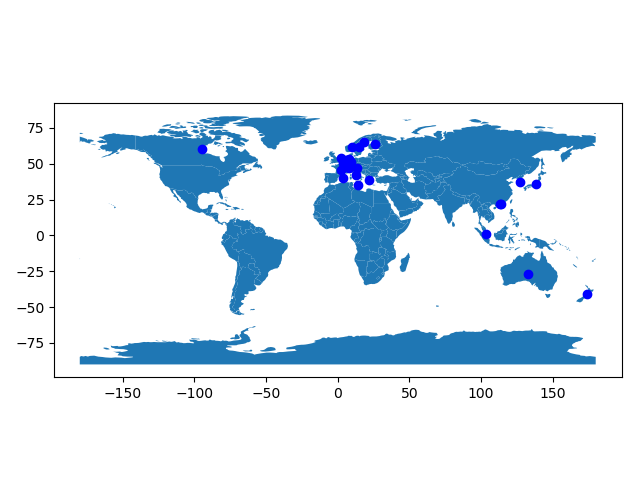

In [24]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='blue')
plt.tight_layout()
plt.show()

In [32]:
y = df_bot[6].loc[:,['coordinates']].reset_index()
y['coordinates'] = y['coordinates'].apply(Point)

gdf2 = geopandas.GeoDataFrame(y,geometry = 'coordinates')

<IPython.core.display.Javascript object>


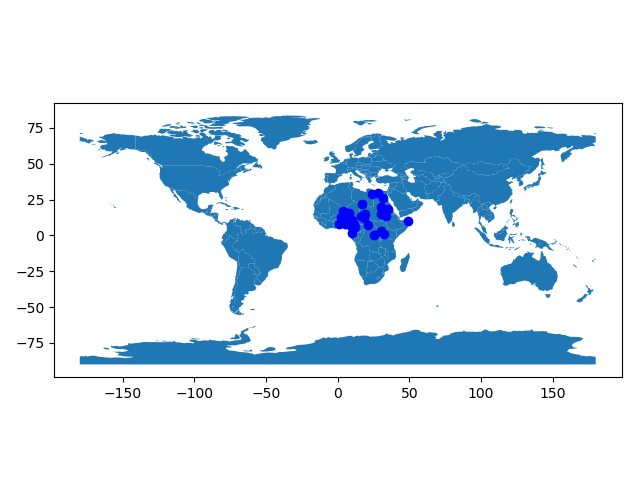

In [37]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot()

# We can now plot our GeoDataFrame.
gdf2.plot(ax=ax, color='blue',figsize=(10,10))
plt.tight_layout()
plt.show()

## Appendix (extra code that didn't make the cut)

In [25]:
# In 2013, Austria's entry contained a typo which added percentages to over 100. Dropped Austria for that year.

# try:
#     df_top[6].drop(index = 'Austria',inplace = True)
#     df_top[6]
# except KeyError:
#     print('Austria already dropped.')

In [26]:
# Goes through ALL of the json files that were pulled from CIA Factbook from resources, extracts industry information
# for each country with high and low life expectancy and stores all the info in a list of dataframes.

# import datetime

# checker = True

# start_date = datetime.datetime.strptime('2007-06-18', '%Y-%m-%d')

# end_date = datetime.datetime.strptime('2017-08-30', '%Y-%m-%d')

# # print(end_date.strftime('%Y-%m-%d'))


# df_top = []
# df_bot = []


# while start_date.strftime('%Y-%m-%d') < end_date.strftime('%Y-%m-%d'):

    
#     JsonFile = f"Resources/weekly_json/{start_date.strftime('%Y-%m-%d')}_factbook.json"

#     dic = {}
#     dic2 = {}

#     with open(JsonFile, 'r', errors = 'ignore') as f:
#         objects = json.loads(f.read())
#         try:
#             for top, bot in zip(top_country_names,bot_country_names):
#                 dic[top] = objects['countries'][top]['data']['economy']['industries']['industries']
#                 dic2[bot] = objects['countries'][bot]['data']['economy']['industries']['industries']
#         except:
#             checker = False
            
#         df_top.append(pd.DataFrame.from_dict(dic, orient = 'index').transpose())
#         df_bot.append(pd.DataFrame.from_dict(dic2, orient = 'index').transpose())
#     print(start_date)
#     start_date += datetime.timedelta(days=7)

        

In [27]:
# print(len(df_top))
# print(len(df_bot))

In [28]:
# x = 'Resources/weekly_json/2007-06-18_factbook.json'

# dic = {}
# dic2 = {}

# with open(JsonFile, 'r') as f:
#     objects = json.loads(f.read())
# #     country = list(objects['countries'].keys())
#     try:
#         for top, bot in zip(top_country_names,bot_country_names):
#             dic[top] = objects['countries'][top]['data']['economy']['industries']['industries']
#             dic2[bot] = objects['countries'][bot]['data']['economy']['industries']['industries']
        
#     except:
#         print(f'{top} not counted as country')

        
# pprint(dic)
# pprint(dic2)

In [29]:
#  df_top[0].loc['Hong Kong','Net Migration Rate']


# def testfunc(df_list,start_year,end_year):
#     dictionary = {}
#     dictionary['Year'] = [x for x in range(start_year,end_year+1)]
#     dictionary['Migration Rate'] = [df.loc['Hong Kong','Net Migration Rate'] for df in df_list]
    
    
#     df = pd.DataFrame(dictionary)
# #     df.set_index('Year', inplace = True,drop = True)
    
#     df.plot(x = 'Year', y = 'Migration Rate',kind = 'line')
#     plt.show()
#     print(df)


# testfunc(df_top,2007,2017)


        
    